# CS 378 Homework 3: The Science of Fairness (100 pts)

## Deadline: 11:59 pm, October 13, 2022

This assignment has three parts. In the first part, you will perform an analysis of fairness on the COMPAS dataset that you previously encountered in Assignment 1. The second and third parts consist of theoretical questions about fairness criteria and causality. 


## Part 1: Further analysis of the COMPAS dataset

### Prelude

Here is the code for loading and cleaning up the dataset.

In [3]:
import pandas as pd
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

pd.options.mode.chained_assignment = None # muting a trivial warning about PANDAS, don't worry about this
df = pd.read_csv('compas-scores-two-years.csv')
df_cleaned = df.loc[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30) 
              & (df['is_recid'] != -1) & (df['c_charge_degree'] != "O") & (df['score_text'] != 'N/A')]
df_filtered = df_cleaned[['age','sex', 'race', 'juv_fel_count', 'decile_score', 'priors_count', 'is_recid', 'is_violent_recid', 
                   'v_decile_score']]
df_final = df_filtered.join(pd.get_dummies(df_filtered['race']))
df_final["sex"] = (df_final["sex"] == "Male") + 0 ## Use the binary coding for sex.
df_final

,age,sex,race,juv_fel_count,decile_score,priors_count,is_recid,is_violent_recid,v_decile_score,African-American,Asian,Caucasian,Hispanic,Native American,Other
0,69,1,Other,0,1,0,0,0,1,0,0,0,0,0,1
1,34,1,African-American,0,3,0,1,1,1,1,0,0,0,0,0
2,24,1,African-American,0,4,4,1,0,3,1,0,0,0,0,0
5,44,1,Other,0,1,0,0,0,1,0,0,0,0,0,1
6,41,1,Caucasian,0,6,14,1,0,2,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,23,1,African-American,0,7,0,0,0,5,1,0,0,0,0,0
7210,23,1,African-American,0,3,0,0,0,5,1,0,0,0,0,0
7211,57,1,Other,0,1,0,0,0,1,0,0,0,0,0,1
7212,33,0,African-American,0,2,3,0,0,2,1,0,0,0,0,0


And here is the code for performing a train-test split, training a logistic regression model, and computing the test accuracy.

In [105]:
X = df_final.drop(columns=['is_recid', 'is_violent_recid', "race"])
Y = df_final['is_recid']

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=137)

In [5]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(max_iter = 2000)
logistic_regression.fit(train_x, train_y)

LogisticRegression(max_iter=2000)

As you know, in logistic regression settings with two classes, one first computes a score, then *thresholds* the score. Thresholding allows you to predict a discrete output and evaluate accuracy. Here is the code for computing the accuracy of the classifier you get when you apply the default threshold of 0.5 to your model.

In [6]:
from sklearn import metrics
lr_prediction = logistic_regression.predict(test_x)
accuracy = metrics.accuracy_score(test_y, lr_prediction)
percent_accuracy = accuracy * 100
percent_accuracy

68.34008097165992

### Questions

In the following, "score" refers to the probability that your logistic regressor computes.

#### Q1: Implement a logistic regression classifier with a threshold 0.7. Report on this classifier's accuracy. (Hint: You don't want to use logistic_regression.predict(...) but a different function in sklearn's LogisticRegression class.)    (5 points)

In [7]:
# YOUR CODE HERE

lr_prediction = logistic_regression.predict_proba(test_x)

#print (lr_prediction)

lr_prediction_df = pd.DataFrame(lr_prediction)
lr_prediction_df = lr_prediction_df.applymap(lambda x: 1 if x > 0.7 else 0).iloc[:, 1:]

thresholdAccuracy = metrics.accuracy_score(test_y, lr_prediction_df)
print ("Percent Accuracy for LR classifier w threshold 0.7", thresholdAccuracy * 100)

Percent Accuracy for LR classifier w threshold 0.7 61.78137651821862


#### Q2: Construct a randomized classifier that selects either a threshold of 0.3 or a threshold of 0.7 (with probabilities of your choosing). Report on this classifier's expected accuracy.      (3 points)

In [8]:
# YOUR CODE HERE
# YOUR CODE HERE

import random
lr_prediction = logistic_regression.predict_proba(test_x)

#print (lr_prediction)

lr_prediction_df = pd.DataFrame(lr_prediction).iloc[:, 1:]

#print (lr_prediction_df)
#print (lr_prediction_df.iloc[0].iat[0])

random.seed(2724)
for i in range(len(lr_prediction_df)):
    rnum = random.randint(0,1) # 50% chance for 0.3 threshold, 50% chance for 0.7 threshold
    if rnum == 0:
        if lr_prediction_df.iloc[i].iat[0] > 0.3:
            lr_prediction_df.iloc[i].iat[0] = 1
        else:
            lr_prediction_df.iloc[i].iat[0] = 0
    else:
        if lr_prediction_df.iloc[i].iat[0] > 0.7:
            lr_prediction_df.iloc[i].iat[0] = 1
        else:
            lr_prediction_df.iloc[i].iat[0] = 0


thresholdAccuracy = metrics.accuracy_score(test_y, lr_prediction_df)
print ("Percent Accuracy for LR classifier w threshold 0.7 with 50% chance and threshold 0.3 the other 50% of the time", thresholdAccuracy * 100)

print ("The expected accuracy of this classifier I think is the same as the accuracy of the threshold 0.7 LR classifier")

Percent Accuracy for LR classifier w threshold 0.7 with 50% chance and threshold 0.3 the other 50% of the time 61.1336032388664
The expected accuracy of this classifier I think is the same as the accuracy of the threshold 0.7 LR classifier


## Fairness properties over race
From now on, we will only focus on the black and white subgroups of the population. 

Assume that the cost of a false positive (predicting recidivism for someone who won't commit recidivism) is 6 times higher than that of a false negative (not predicting recidivism for someone who will commit recidivism).
Consider four strategies for threholding the logistic score that we discussed in class:

* Maximum profit: Pick group-dependent score thresholds in a way that maximizes profit ("maximizing profit" is just another name for "minimizing cost", where the costs are as described above).
* Single threshold: Pick a single uniform threshold for all groups in a way that maximizes profit.
* Separation: Achieve an approximately equal true/false positive rate in all groups. Subject to this constraint, maximize profit.
* Independence: Achieve an approximately equal acceptance rate in all groups. Subject to this constraint, maximize profit.


#### Q3: Give code to find (possibly randomized) binary classifiers that sets thresholds for the black and white subgroups according to the above four strategies. You can use any algorithm you like for finding the thresholds. (20 points)

In [39]:
from sklearn.metrics import confusion_matrix

# YOUR CODE HERE
def cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (6*fp + fn)/len(y_true)

# maximum profit, group-dependent score thresholds

allPossibleThresholds = [i/100 for i in range(101)]

blackSumCorrect = 0
blackTotal = 0
whiteSumCorrect = 0
whiteTotal = 0

test_x_white = test_x[test_x['Caucasian'] == 1]
test_y_white = test_y[test_x['Caucasian'] == 1]

#test_x_white.head()

test_x_black = test_x[test_x['African-American'] == 1]
test_y_black = test_y[test_x['African-American'] == 1]

#print(type((test_x['African-American'] | test_x['Caucasian']) == 1))

#test_x = test_x[(test_x['African-American'] | test_x['Caucasian']) == 1]


test_x_wb = test_x[(test_x['African-American'] | test_x['Caucasian']) == 1]
test_y_wb = test_y[(test_x['African-American'] | test_x['Caucasian']) == 1]

# print(test_x_wb.head())
# print (test_y_wb.head())
# print ("--------")
# print (test_x.head())
# print (test_y.head())

#test_x_black.head()
#test_x_white = test_x[test_x.race == "Caucasion"]

lr_prediction_black = pd.DataFrame(logistic_regression.predict_proba(test_x_black)[:, 1:])
lr_prediction_white = pd.DataFrame(logistic_regression.predict_proba(test_x_white)[:, 1:])
minBlackCost = float("inf")
minBlackThreshold = -1
for threshold in allPossibleThresholds:
    lr_prediction_black_threshold = lr_prediction_black.applymap(lambda x: 1 if x > threshold else 0)
    cost_threshold = cost(test_y_black, lr_prediction_black_threshold)
    
    if cost_threshold < minBlackCost:
        minBlackCost = cost_threshold
        minBlackThreshold = threshold
        
minWhiteCost = float("inf")
minWhiteThreshold = -1
for threshold in allPossibleThresholds:
    lrpwt = lr_prediction_white.applymap(lambda x: 1 if x > threshold else 0)
    cost_threshold = cost(test_y_white, lrpwt)
    
    if cost_threshold < minWhiteCost:
        minWhiteCost = cost_threshold
        minWhiteThreshold = threshold
    
#print ('chill')   
print ("Maximum Profit:")
print ("Black subgroup threshold: ", minBlackThreshold)
print ("White subgroup threshold: ", minWhiteThreshold)
print ("---------------")

lr_prediction = pd.DataFrame(logistic_regression.predict_proba(test_x_wb)[:, 1:])
minCost = float("inf")
minSingleThreshold = -1
for threshold in allPossibleThresholds:
    lr_prediction_threshold = lr_prediction.applymap(lambda x: 1 if x > threshold else 0)
    cost_threshold = cost(test_y_wb, lr_prediction_threshold)
    #print (threshold, cost_threshold)
    if cost_threshold < minCost:
        minCost = cost_threshold
        minSingleThreshold = threshold
print ("Single Threshold: ", minThreshold)
print ("---------------")

# YOUR CODE HERE
def separation_cost(l): # accepts a list of tuples of tp and fp rates,
    # computes variance of tp and variance of fp rates and adds them together
    
    tpL = [x[0] for x in l]
    tpMean = sum(tpL)/len(tpL)
    tpVar = sum([(tp - tpMean)**2 for tp in tpL])/len(tpL)
    
    fpL = [x[1] for x in l]
    fpMean = sum(fpL)/len(fpL)
    fpVar = sum([(fp - fpMean)**2 for fp in fpL])/len(fpL)
    
    return tpVar + fpVar

minCost = float("inf")
minSeparationThreshold = -1
separationLambda = 30 # hyperparameter chosen
minSeparationList = None
for threshold in allPossibleThresholds:
    lr_prediction_black_threshold = lr_prediction_black.applymap(lambda x: 1 if x > threshold else 0)
    lr_prediction_white_threshold = lr_prediction_white.applymap(lambda x: 1 if x > threshold else 0)
    lr_prediction_threshold = lr_prediction.applymap(lambda x: 1 if x > threshold else 0)
    fpfncost = cost(test_y_wb, lr_prediction_threshold)
    
    btn, bfp, bfn, btp = confusion_matrix(test_y_black, lr_prediction_black_threshold).ravel()
    #print (btn, bfp, bfn, btp)
    wtn, wfp, wfn, wtp = confusion_matrix(test_y_white, lr_prediction_white_threshold).ravel()
    
    separationList = [(btp/(btp + bfn), bfp/(bfp + btn)), (wtp/(wtp + wfn), wfp/(wtp + wfn))]
    
    curCost = fpfncost + separationLambda * separation_cost(separationList)
    if curCost < minCost:
        minCost = curCost
        minSeparationThreshold = threshold
        minSeparationList = separationList
        #print (minSeparationList)

print ("Separation Threshold: ", minSeparationThreshold)
print ("Black (TP,FP): ", minSeparationList[0])
print ("White (TP,FP): ", minSeparationList[1])
print ("---------------")


def independence_cost(l): # accepts a list of acceptance rates aka (tp + fp)/(tp + tn + fn + fp)
    # computes variance of acceptance rate
    
    aL = [x for x in l]
    aMean = sum(aL)/len(aL)
    aVar = sum([(a - aMean)**2 for a in aL])/len(aL)
    return aVar

minCost = float("inf")
minIndependenceThreshold = -1
independenceLambda = 10 # hyperparameter chosen
minIndependenceList = None
for threshold in allPossibleThresholds:
    lr_prediction_black_threshold = lr_prediction_black.applymap(lambda x: 1 if x > threshold else 0)
    lr_prediction_white_threshold = lr_prediction_white.applymap(lambda x: 1 if x > threshold else 0)
    lr_prediction_threshold = lr_prediction.applymap(lambda x: 1 if x > threshold else 0)
    fpfncost = cost(test_y_wb, lr_prediction_threshold)
    
    btn, bfp, bfn, btp = confusion_matrix(test_y_black, lr_prediction_black_threshold).ravel()
    #print (btn, bfp, bfn, btp)
    wtn, wfp, wfn, wtp = confusion_matrix(test_y_white, lr_prediction_white_threshold).ravel()
    
    independenceList = [(btp + bfp)/len(test_y_black), (wtp + wfp)/len(test_y_white)]
    
    curCost = fpfncost + independenceLambda * independence_cost(independenceList)
    if curCost < minCost:
        minCost = curCost
        minIndependenceThreshold = threshold
        minIndependenceList = independenceList
        #print (minSeparationList)

print ("Independence Threshold: ", minIndependenceThreshold)
print ("Black Acceptance Rate: ", minIndependenceList[0])
print ("White Acceptance Rate: ", minIndependenceList[1])


    
    

        
    

Maximum Profit:
Black subgroup threshold:  0.81
White subgroup threshold:  0.76
---------------
Single Threshold:  0.93
---------------
Separation Threshold:  0.95
Black (TP,FP):  (0.031609195402298854, 0.0036363636363636364)
White (TP,FP):  (0.011834319526627219, 0.0)
---------------
Independence Threshold:  0.93
Black Acceptance Rate:  0.027287319422150885
White Acceptance Rate:  0.00477326968973747


I know the separation threshold is quite high, but I think that this is 1) a result of the false positives being penalized 6 times more harshly (which is why the single threshold is also very high).  I chose the lambda hyperparameter to weight the separation constraint in such a way that it does not always pick positive, but that it is different from the answer chosen for single threshold.  The single threshold answer is quite high, but after printing out the (threshold, cost) tuple, I found it to be reasonable and that (0.93 0.4846449136276392) barely beat out lower threshold values such as (0.81 0.491362763915547).

#### Q4: Show the ROC curves for the black and white subgroups, and plot the points corresponding to the different strategies clearly identified. The resulting curve should look like the ROC curve in the FICO score case study that was discussed in class.  (5 points)

<Figure size 432x288 with 0 Axes>

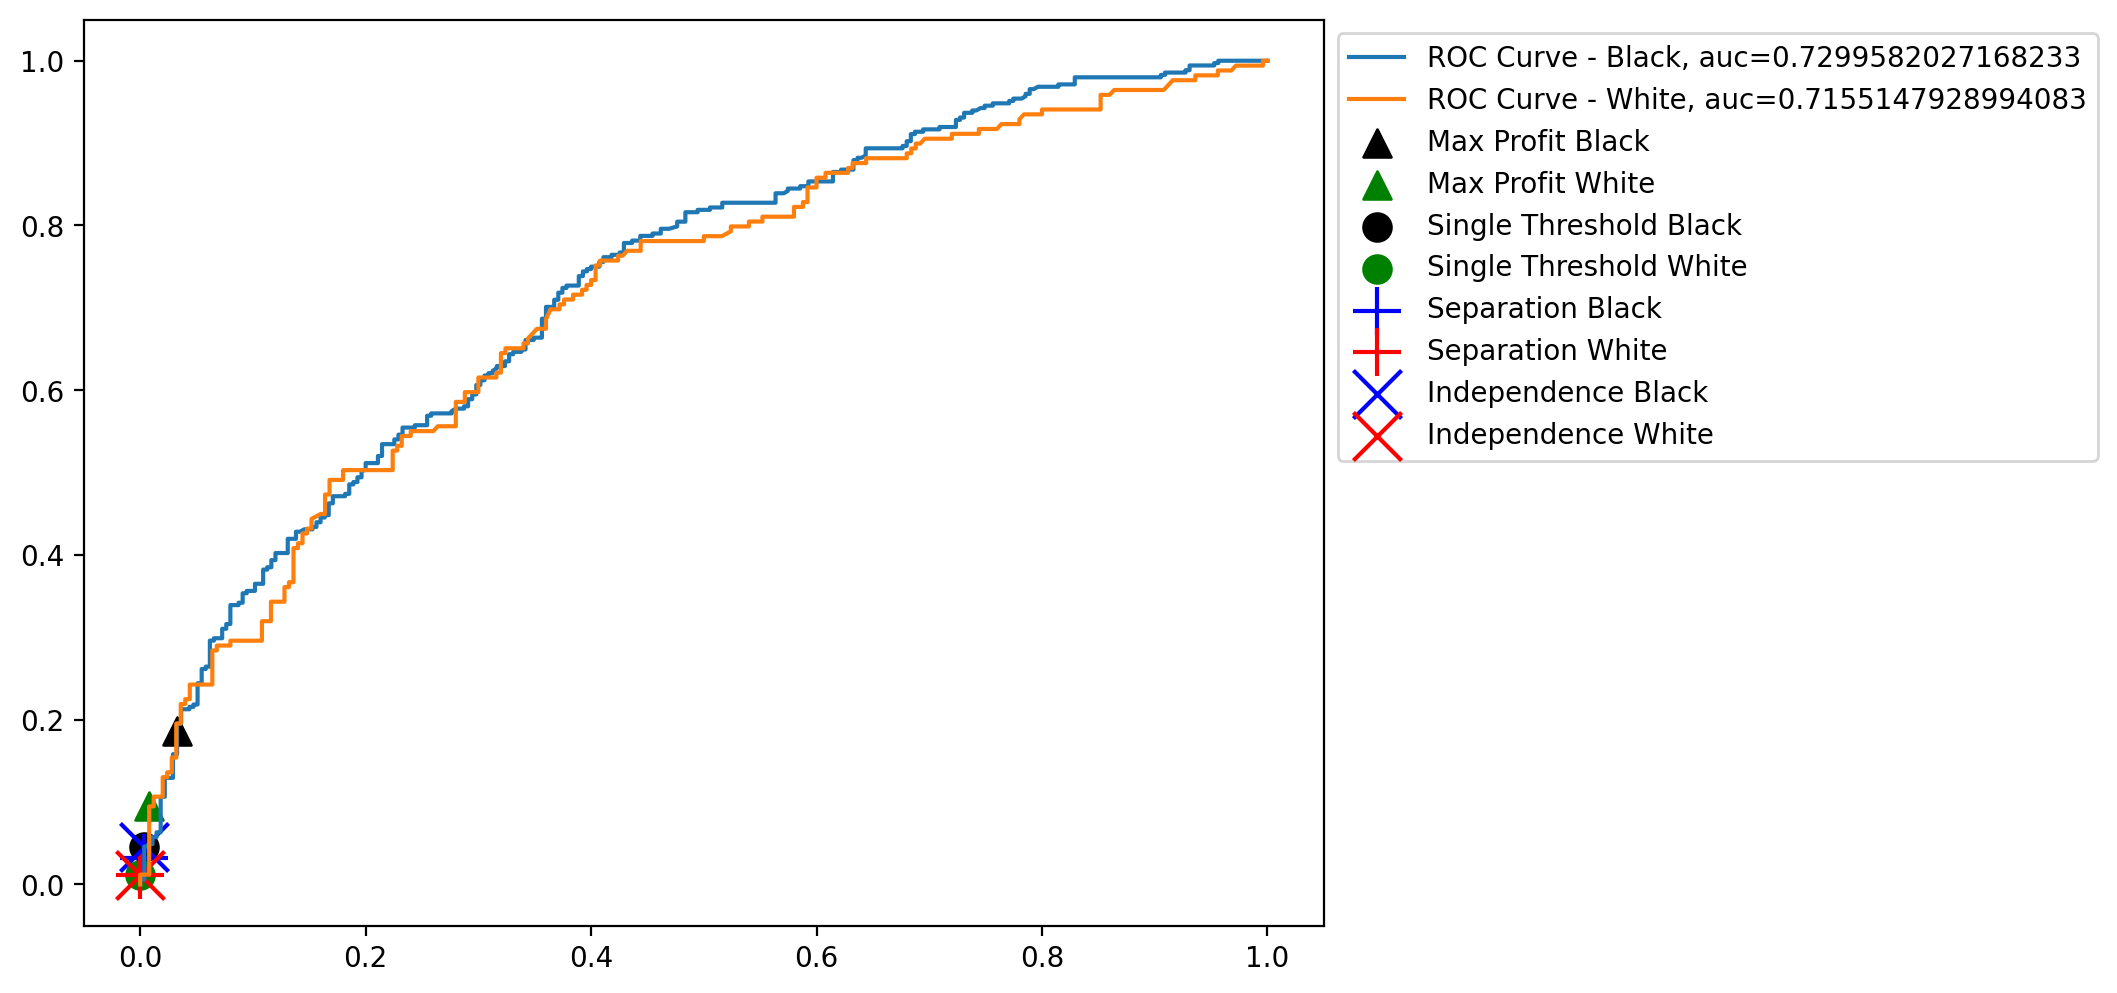

In [88]:
import matplotlib.pyplot as plt

# YOUR CODE HERE
'''fpr_w, tpr_w, thresholds_w = metrics.roc_curve(test_y_white, lr_prediction_white)
roc_auc_w = metrics.auc(fpr_w, tpr_w)
display = metrics.RocCurveDisplay(fpr=fpr_w, tpr=tpr_w, roc_auc=roc_auc_w, estimator_name='White ROC Curve')
display.plot()


# black ROC curve
fpr_b, tpr_b, thresholds_b = metrics.roc_curve(test_y_black, lr_prediction_black)
roc_auc_b = metrics.auc(fpr_b, tpr_b)
display2 = metrics.RocCurveDisplay(fpr=fpr_b, tpr=tpr_b, roc_auc=roc_auc_b, estimator_name='Black ROC Curve')
display2.plot()
plt.show();'''

from matplotlib.pyplot import figure



plt.figure(0).clf()



fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

#figure(figsize=(8, 6), dpi=200)



fpr_b, tpr_b, thresholds_b = metrics.roc_curve(test_y_black, lr_prediction_black)
auc = metrics.roc_auc_score(test_y_black, lr_prediction_black)
plt.plot(fpr_b,tpr_b,label="ROC Curve - Black, auc="+str(auc))

fpr_w, tpr_w, thresholds_w = metrics.roc_curve(test_y_white, lr_prediction_white)
auc = metrics.roc_auc_score(test_y_white, lr_prediction_white)
plt.plot(fpr_w,tpr_w,label="ROC Curve - White, auc="+str(auc))

lr_prediction_black_threshold = lr_prediction_black.applymap(lambda x: 1 if x > minBlackThreshold else 0)
lr_prediction_white_threshold = lr_prediction_white.applymap(lambda x: 1 if x > minWhiteThreshold else 0)

btn, bfp, bfn, btp = confusion_matrix(test_y_black, lr_prediction_black_threshold).ravel()
wtn, wfp, wfn, wtp = confusion_matrix(test_y_white, lr_prediction_white_threshold).ravel()


ax.scatter(bfp/(bfp + btn), btp/(btp + bfn), c='black', marker='^', s=100, label='Max Profit Black')
ax.scatter(wfp/(wfp + wtn), wtp/(wtp + wfn), c='green', marker='^', s= 100, label="Max Profit White")

lr_prediction_black_threshold = lr_prediction_black.applymap(lambda x: 1 if x > minThreshold else 0)
lr_prediction_white_threshold = lr_prediction_white.applymap(lambda x: 1 if x > minThreshold else 0)

btn, bfp, bfn, btp = confusion_matrix(test_y_black, lr_prediction_black_threshold).ravel()
wtn, wfp, wfn, wtp = confusion_matrix(test_y_white, lr_prediction_white_threshold).ravel()
    
ax.scatter(bfp/(bfp + btn), btp/(btp + bfn), c='black', marker='o', s=100, label="Single Threshold Black")
ax.scatter(wfp/(wfp + wtn), wtp/(wtp + wfn), c='green', marker='o',s=100, label="Single Threshold White")

lr_prediction_black_threshold = lr_prediction_black.applymap(lambda x: 1 if x > minSeparationThreshold else 0)
lr_prediction_white_threshold = lr_prediction_white.applymap(lambda x: 1 if x > minSeparationThreshold else 0)

btn, bfp, bfn, btp = confusion_matrix(test_y_black, lr_prediction_black_threshold).ravel()
wtn, wfp, wfn, wtp = confusion_matrix(test_y_white, lr_prediction_white_threshold).ravel()
    
ax.scatter(bfp/(bfp + btn), btp/(btp + bfn), c='blue', marker='+',s=300, label="Separation Black")
ax.scatter(wfp/(wfp + wtn), wtp/(wtp + wfn), c='red', marker='+', s=300, label="Separation White")

lr_prediction_black_threshold = lr_prediction_black.applymap(lambda x: 1 if x > minIndependenceThreshold else 0)
lr_prediction_white_threshold = lr_prediction_white.applymap(lambda x: 1 if x > minIndependenceThreshold else 0)

btn, bfp, bfn, btp = confusion_matrix(test_y_black, lr_prediction_black_threshold).ravel()
wtn, wfp, wfn, wtp = confusion_matrix(test_y_white, lr_prediction_white_threshold).ravel()
    
ax.scatter(bfp/(bfp + btn), btp/(btp + bfn), c='blue', marker='x',s=300, label="Independence Black")
ax.scatter(wfp/(wfp + wtn), wtp/(wtp + wfn), c='red', marker='x', s=300, label="Independence White")




#legend1 = ax.legend(loc="upper left", title="Points")
#ax.add_artist(legend1)

plt.legend(loc=0, bbox_to_anchor=(1,1))

#### Q5: (i) Do a calibration plot that plots the fraction of defendants recidividating within two years as a function of the predicted probability of recidivism, for black defendants and white defendants. (ii) Comment (in a couple of sentences) if you believe that the score satisfies sufficiency across racial groups.      (5 points)

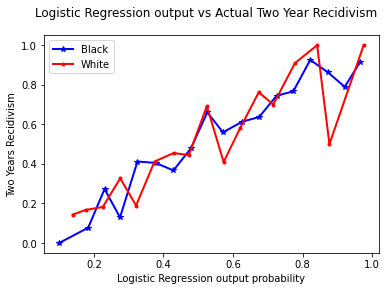

In [89]:
# YOUR CODE HERE 
from sklearn.calibration import calibration_curve
y_b, x_b = calibration_curve(
    test_y_black, 
    lr_prediction_black, 
    n_bins=20)

y_w, x_w = calibration_curve(
    test_y_white, 
    lr_prediction_white, 
    n_bins=20)


fig, ax = plt.subplots()

plt.plot(x_b, y_b, color='blue', 
         marker='*', 
         linewidth = 2, 
         label='Black')

plt.plot(x_w, y_w, color='red', 
         marker='.', 
         linewidth = 2, 
         label='White')

# # reference line, legends, and axis labels
ax.set_xlabel('Logistic Regression output probability')
ax.set_ylabel('Two Years Recidivism')
fig.suptitle('Logistic Regression output vs Actual Two Year Recidivism')
plt.legend()
plt.show()



Being sufficient means Y _|_ A | R.  As in general, both line graphs closely follows each other, I think that sufficiency does indeed hold true here.

#### Q6: (i) Plot the distributions of scores received by the positive class (recidivists) and the distribution of scores received by the negative class (non-recidivists) for black and white defendants. (ii) Based on these plots, comment (in a couple of sentences) if this score satisfies separation.  (5 points)

/var/folders/3k/nhgpsd_x0y5111nl043x8tgh0000gn/T/ipykernel_5678/2890315645.py:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lr_prediction_white_nonrecid,
/var/folders/3k/nhgpsd_x0y5111nl043x8tgh0000gn/T/ipykernel_5678/2890315645.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lr_predict

'\n\nindex_val_one = all_of_w[\'is_recid\'] == 1\nall_of_w_pos = all_of_w.loc[index_val_one]\nall_of_w_pos = all_of_w_pos.drop(columns = ["is_recid"])\nprob_w_g_pos = logistic_regression.predict_proba(all_of_w_pos)\npred_w_g_pos = prob_w_g_pos[:,1]\n\nindex_val_two = all_of_w[\'is_recid\'] == 0\nall_of_w_neg = all_of_w.loc[index_val_two]\nall_of_w_neg = all_of_w_neg.drop(columns = ["is_recid"])\nprob_w_g_neg = logistic_regression.predict_proba(all_of_w_neg)\npred_w_g_neg = prob_w_g_neg[:,1]'

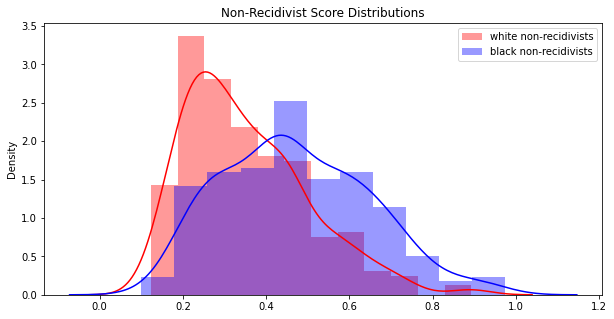

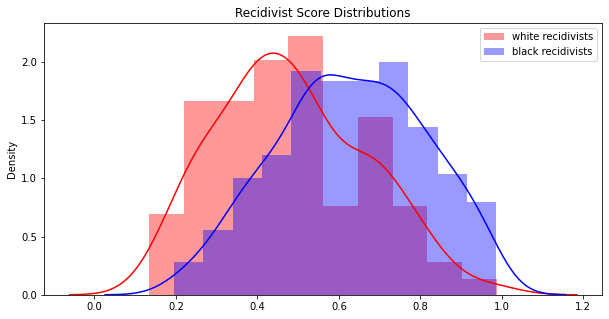

In [100]:
# YOUR CODE HERE

#print (test_y_white.head())



#all_of_w = test_x_w.join(test_y_w)

test_x_white_recid = test_x_white[test_y_white == 1]
test_y_white_recid = test_y_white[test_y_white == 1]
test_x_white_nonrecid = test_x_white[test_y_white == 0]
test_y_white_nonrecid = test_y_white[test_y_white == 0]

#print (test_x_white_nonrecid.head())

lr_prediction_white_recid = logistic_regression.predict_proba(test_x_white_recid)[:, 1:]
lr_prediction_white_nonrecid = logistic_regression.predict_proba(test_x_white_nonrecid)[:, 1:]


test_x_black_recid = test_x_black[test_y_black == 1]
test_y_black_recid = test_y_black[test_y_black == 1]
test_x_black_nonrecid = test_x_black[test_y_black == 0]
test_y_black_nonrecid = test_y_black[test_y_black == 0]

#print (test_x_black_nonrecid.head())

lr_prediction_black_recid = logistic_regression.predict_proba(test_x_black_recid)[:, 1:]
lr_prediction_black_nonrecid = logistic_regression.predict_proba(test_x_black_nonrecid)[:, 1:]

import seaborn as sns
plt.figure(figsize=(10,5))
sns.distplot(lr_prediction_white_nonrecid, 
             color="red", 
             label="white non-recidivists").set(title = "Non-Recidivist Score Distributions")
sns.distplot(lr_prediction_black_nonrecid, 
             color="blue", 
             label="black non-recidivists").set(title = "Non-Recidivist Score Distributions")
plt.legend()

import seaborn as sns
plt.figure(figsize=(10,5))
sns.distplot(lr_prediction_white_recid, 
             color="red", 
             label="white recidivists").set(title = "Recidivist Score Distributions")
sns.distplot(lr_prediction_black_recid, 
             color="blue", 
             label="black recidivists").set(title = "Recidivist Score Distributions")
plt.legend()






'''

index_val_one = all_of_w['is_recid'] == 1
all_of_w_pos = all_of_w.loc[index_val_one]
all_of_w_pos = all_of_w_pos.drop(columns = ["is_recid"])
prob_w_g_pos = logistic_regression.predict_proba(all_of_w_pos)
pred_w_g_pos = prob_w_g_pos[:,1]

index_val_two = all_of_w['is_recid'] == 0
all_of_w_neg = all_of_w.loc[index_val_two]
all_of_w_neg = all_of_w_neg.drop(columns = ["is_recid"])
prob_w_g_neg = logistic_regression.predict_proba(all_of_w_neg)
pred_w_g_neg = prob_w_g_neg[:,1]'''


Separation means that R _|_ A | Y.  So given the true label of recidivism, the logistic regression output must be independent of the race sensitive variable A.  This does NOT satisfy separation, because for both labels (non-recidivists and recidivists), we can see that the model outputted significantly lower scores for white people.

#### Q7: Compute the recidivism rate of defendants aged 25 or lower, and confirm that it is higher than that of older defendants.  (2 points)

In [104]:
# CODE HERE 

young_x = test_x[test_x['age'] <= 25]
young_y = test_y[test_x['age'] <= 25]

old_x = test_x[test_x['age'] > 25]
old_y = test_y[test_x['age'] > 25]

youngRecidivismRate = young_y.mean()
oldRecidivismRate = old_y.mean()

print ("Younger than or equal to 25 recidivism rate: ", youngRecidivismRate)
print ("Older than 25 recidivism rate: ", oldRecidivismRate)


Younger than or equal to 25 recidivism rate:  0.5730994152046783
Older than 25 recidivism rate:  0.45128779395296753


## Part 2: Theoretical questions about fairness criteria

For this part of the assignment, you might need to use Latex math. Note that Jupyter notebook's markdown format supports this! For example, here is the definition of the sigmoid function: $\sigma(x) = \frac{1}{1 + e^{-x}}$.

#### Q8: Suppose you want to require the following property from an AI system that is making decisions on loans: "People who pay back their loan, have an equal opportunity of getting the loan in the first place". On the other hand, there is no requirement for those that will ultimately default. Come up with a formal property, in terms of the sensitive characteristic $A$, a score $R$, and a target label $Y$, that would capture this requirement. Comment on how this property relates to the properties of separation, independence, and sufficiency.   (8 points)

Note that I will be using _|_ to mean independent.

Answer: R _|_ A | Y.  This is saying that given Y (knowing whether one will paying back loan or not), the AI system does not gain any information based on knowing A or not, and hence its score R is independent of A. So, this satisfies separation, and that each group has the same false positive and false negative rate (and I think that this holds for all thresholds, because the distribution over the score R is the same).

#### Q9: Suppose you want to require the following property from an AI system: "Controlling for a limited set of legitimate risk factors, an equal proportion of defendants are detained within each race group." Come up with a formal property, in terms of $A$, $R$, and $Y$, that would capture this requirement. Comment on how this property relates to the properties of separation, independence, and sufficiency.   (7 points)

Answer: The second part of this property is saying that an equal proportion of defendants are detained within each race group, so from that we have that Y _|_ A (Pr[Y = 1 | A = a] = Pr[Y = 1 | A = b]).  But, the first part says to control for a limited set of legitimate risk factors (which is the models output R).  So, we can add this to be conditioned on.  So, finally, we have that Pr[Y = 1 | A = a, R = r] = Pr[Y = 1 | A = b, R = r].  Hence, we have Y _|_ A | R.  This is the sufficiency property, meaning that the legitimate attributes (R) are sufficient/enough in predicting whether the defendant is detained without the need for the sensitive attribute (A) at all.

#### Q10: In class, we proved the following result. Assume that $Y$ is binary, that $A$ is not independent of $Y$, and that $R$ is not independent of $Y$. Then, independence ($R \perp A$) and separation ($R \perp A| Y$) cannot both hold. Give a counterexample that shows that this claim does not hold if $Y$ assumes three distinct values.     (10 points)

Answer: By looking at the proof in class, if we look at this penultimate line right here:

$$r_0 p_a + r_1 (1 - p_a) = p r_0 + (1 - p)r_1$$

If we modify this to account for Y being ternary, we have:

$$r_0 p_a + r_1 p_{1,a} + r_2 (1 - p_a - p_{1,a}) = p r_0 + p_1 r_1 + (1 - p - p_1) r_2$$

Since Y is not independent of A, there must be a case that $$p \neq p_a, \forall a$$ and that $$p_1 \neq p_{1,a}, \forall a$$.  Hence, this equation above does not have to hold true.

## Part 3: Theoretical questions about causality

Before answering Q11, read [this page](http://bayes.cs.ucla.edu/BOOK-2K/d-sep.html) on d-separation, a way of determining independence relationships in causal graphs.

#### Q11: Consider the following causal graph. (i) Are the variables $A$ and $F$ independent? (ii) What about $A$ and $B$? (iii) What about $A$ and $B$ when you condition on $C$ (i.e., when you are restricting to a specific observed value of $C$)? (iv) Show the graph obtained by doing an intervention on the variable $E$. (v) Write down the probability distribution $P_{M[E := 0]}(A, B, C, D, F, G, H)$ in terms of the conditional probabilities corresponding to the various edges of the graph (e.g., $P(A)$, $P(C | D)$, etc.) ![samplegraph.png](attachment:samplegraph.png)     (10 points)

YOUR ANSWER HERE

(i) Are the variables  𝐴  and  𝐹  independent? As there is an unblocked path from A to F, A and F are NOT independent.

(ii) What about  𝐴  and  𝐵 ? As there is no unblocked path from A to B, A and B are independent (C is a collider)

(iii) What about  𝐴  and  𝐵  when you condition on  𝐶  (i.e., when you are restricting to a specific observed value of  𝐶 )?  By rule 3, since C is a collider that is a member of the conditioning set, C no longer blocks the path from A to B, and hence there is a path from A to B, so A and B are not independent.

(iv) It's the same as the given graph, but all incoming edges to E are deleted

(v) P(A) * P(D) * P(C | A,D) * P(F | C) * P(B | D) * P(G | D) * P(H | E = 0)



## Questions 12 & 13

The following table shows a famous dataset for kidney stone recovery. Out of 700 patients, one half has been treated with open surgery (Treatment A; 78% recovery rate) the other with percutaneous nephrolithotomy (Treatment B; with 83% success), a surgical procedure to remove kidney stones by a small puncture wound. If we did not know anything else than the overall recovery rates, many people would prefer treatment B if they had to decide. Observing the data in more detail, however, we realize that treatment A performs better on both small and
large kidney stones.

| Treatment | Overall recovery rate | Recovery rate for small stones | Recovery rate for large stones 
| --- | --- | --- | --- |
| A | 78% (273/350) | 93% (81/87) | 73% (192/263)
| B | 83% (289/350) | 87% (234/270)| 69% (55/80)

Our goal in this exercise is to use the tools of causal inference to decide if Treatment A is preferable to Treatment B. 

#### Q12: Consider the following causal graph. Here, $Z$ is the size of the stone, $T$ the treatment, and $R$ the recovery (all binary). We imagine that $T = 1$  if treatment A is administered, and $T = 0$ if treatment B is administered. Compute $P_{M[T:=1]}(R = 1)$, $P_{M[T:=0]}(R = 1)$, $P(R = 1 | T = 1)$, and $P(R = 1 | T = 0)$, where $M$ is the original model.      (16 points)

![kidneygraph.png](attachment:kidneygraph.png)

YOUR ANSWER HERE

$$P_{M[T:=1]}(R = 1) = P(R = 1 | T = 1) = P(R = 1 | T = 1, Z = \text{small})P(Z = \text{small}) + P(R = 1 | T = 1, Z = \text{big})P(Z = \text{big}) \\
= 0.93 * \frac{357}{700} + 0.73 * \frac{343}{700} = 0.832$$

$$P_{M[T:=0]}(R = 1) = P(R = 1 | T = 0) = P(R = 1 | T = 0, Z = \text{small})P(Z = \text{small}) + P(R = 1 | T = 0, Z = \text{big})P(Z = \text{big}) \\
= 0.87 * \frac{357}{700} + 0.69 * \frac{343}{700} = 0.7818$$



#### Q13:  Compute the average treatment effect for $T$. Based on this computation, which treatment should we use for this condition?       (4 points)

YOUR ANSWER HERE

The average treatment effect for T = 1 is calculated above to be 0.832.  The average treatment effet for T = 0 is calculated above to be 0.7818.  As the average treatment effect for T = 1 (treatment A) is higher, treatment A should be used to treat this condition.  Also, in both sizes, treatment A had a higher recovery rate.

#### Q14 (OPTIONAL): How difficult was this homework and how many hours did you spend on it? (0 points) 

very time consuming, probably 15 hours